# Eval domain adaptation exp1.1

## Environment setup

In [1]:
!pip -q install -U datasets transformers evaluate scikit-learn

import numpy as np
from datasets import load_dataset
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Your target 9 labels (order matters)
TARGET_LABELS = [
    "anger", "anticipation", "caring", "disgust", "fear",
    "joy", "neutral", "sadness", "surprise"
]
label2id = {l:i for i,l in enumerate(TARGET_LABELS)}
id2label = {i:l for l,i in label2id.items()}

# GoEmotions original labels (28)
ORIG_LABELS = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
    "joy", "love", "nervousness", "optimism", "pride", "realization",
    "relief", "remorse", "sadness", "surprise", "neutral"
]
orig_id2label = {i:n for i,n in enumerate(ORIG_LABELS)}

# Your mapping 28 → 9
EMOTION_MAP = {
    "anger": "anger", "annoyance": "anger", "disapproval": "anger",
    "optimism": "anticipation", "curiosity": "anticipation", "desire": "anticipation",
    "caring": "caring", "love": "caring", "admiration": "caring", "gratitude": "caring", "approval": "caring",
    "disgust": "disgust",
    "fear": "fear", "nervousness": "fear",
    "joy": "joy", "excitement": "joy", "amusement": "joy", "pride": "joy", "relief": "joy",
    "neutral": "neutral",
    "sadness": "sadness", "disappointment": "sadness", "grief": "sadness", "remorse": "sadness", "embarrassment": "sadness",
    "surprise": "surprise", "confusion": "surprise", "realization": "surprise"
}

def map_multi_labels_to_single_9(old_indices):
    """
    GoEmotions samples can have multiple labels.
    For single-label evaluation, we pick ONE target label by majority vote
    over mapped labels; ties broken deterministically.
    """
    mapped = []
    for old_idx in old_indices:
        name = orig_id2label[int(old_idx)]
        if name in EMOTION_MAP:
            mapped.append(EMOTION_MAP[name])
    if len(mapped) == 0:
        return None  # should be rare

    # majority vote among mapped
    counts = {}
    for m in mapped:
        counts[m] = counts.get(m, 0) + 1

    # tie-break using TARGET_LABELS order
    best = sorted(counts.items(), key=lambda kv: (-kv[1], TARGET_LABELS.index(kv[0])))[0][0]
    return label2id[best]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 142.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 55.1 MB/s eta 0:00:00


## Load and clean GoEmotions

In [2]:
dataset = load_dataset("go_emotions", "simplified")

# filter unclear if exists
for split in ["train", "validation", "test"]:
    if "example_very_unclear" in dataset[split].column_names:
        dataset[split] = dataset[split].filter(lambda x: x["example_very_unclear"] == 0)

test_raw = dataset["test"]

# build single-label targets
y_true = []
texts = []
skipped = 0

for ex in test_raw:
    y = map_multi_labels_to_single_9(ex["labels"])
    if y is None:
        skipped += 1
        continue
    y_true.append(y)
    texts.append(ex["text"])

y_true = np.array(y_true, dtype=np.int64)
print("GoEmotions test examples used:", len(y_true), "skipped:", skipped)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

GoEmotions test examples used: 5427 skipped: 0


## Load model and tokenizer

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = "cuda" if torch.cuda.is_available() else "cpu"

BASELINE_MODEL_PATH = "/content/drive/MyDrive/VibeQ-EIE/models/student_singlelabel_9emotions_v1"
FINAL_MODEL_PATH    = "/content/drive/MyDrive/VibeQ-EIE/models/student_distilled_9_v1"

def predict_softmax(model_path, texts, batch_size=32, max_length=192):
    tok = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    model.eval()

    all_preds = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
            enc = {k:v.to(device) for k,v in enc.items()}
            logits = model(**enc).logits
            preds = torch.argmax(torch.softmax(logits, dim=-1), dim=-1)
            all_preds.append(preds.detach().cpu().numpy())

    return np.concatenate(all_preds, axis=0)

y_pred_baseline = predict_softmax(BASELINE_MODEL_PATH, texts)
y_pred_final    = predict_softmax(FINAL_MODEL_PATH, texts)

print("pred shapes:", y_pred_baseline.shape, y_pred_final.shape, "y_true:", y_true.shape)


pred shapes: (5427,) (5427,) y_true: (5427,)


## Evaluation helpers

In [4]:
def eval_singlelabel(y_true, y_pred, title="MODEL"):
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)  # == accuracy for single-label
    acc   = (y_true == y_pred).mean()

    print(f"\n===== {title} =====")
    print("Accuracy :", round(float(acc), 4))
    print("F1-micro :", round(float(micro), 4))
    print("F1-macro :", round(float(macro), 4))
    print("\nPer-class report:")
    print(classification_report(
        y_true, y_pred,
        target_names=TARGET_LABELS,
        zero_division=0
    ))

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(TARGET_LABELS))))
    return cm

cm_base = eval_singlelabel(y_true, y_pred_baseline, "BASELINE (GoEmotions-only)")
cm_final = eval_singlelabel(y_true, y_pred_final, "FINAL (Student/Distilled)")



===== BASELINE (GoEmotions-only) =====
Accuracy : 0.6287
F1-micro : 0.6287
F1-macro : 0.5803

Per-class report:
              precision    recall  f1-score   support

       anger       0.56      0.55      0.56       726
anticipation       0.57      0.43      0.49       510
      caring       0.74      0.73      0.74      1376
     disgust       0.52      0.47      0.50        91
        fear       0.70      0.63      0.67        90
         joy       0.62      0.68      0.65       409
     neutral       0.61      0.69      0.65      1643
     sadness       0.57      0.62      0.60       298
    surprise       0.48      0.31      0.38       284

    accuracy                           0.63      5427
   macro avg       0.60      0.57      0.58      5427
weighted avg       0.63      0.63      0.62      5427


===== FINAL (Student/Distilled) =====
Accuracy : 0.6088
F1-micro : 0.6088
F1-macro : 0.5547

Per-class report:
              precision    recall  f1-score   support

       anger   

## Plot confusion matrix

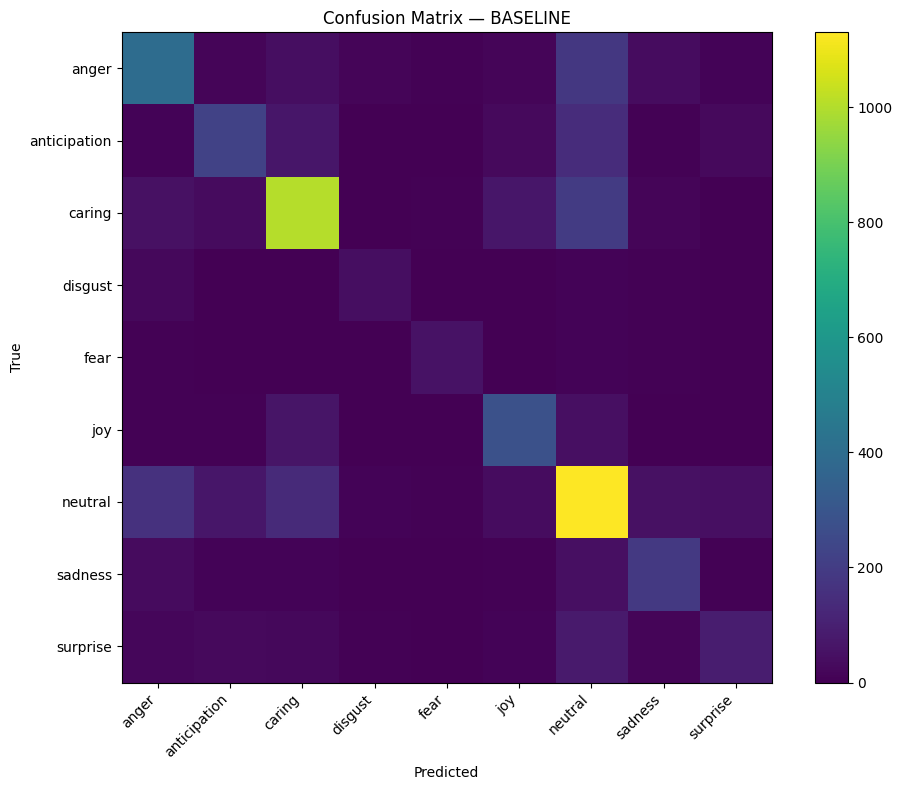

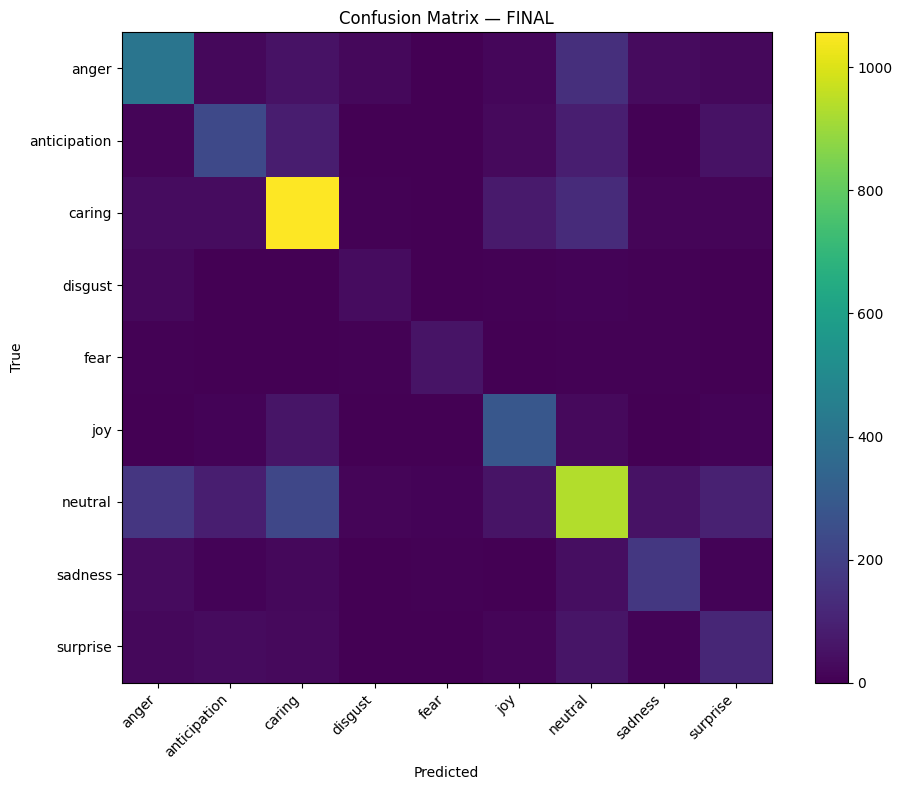

In [5]:
import matplotlib.pyplot as plt

def plot_cm(cm, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(TARGET_LABELS))
    plt.xticks(tick_marks, TARGET_LABELS, rotation=45, ha="right")
    plt.yticks(tick_marks, TARGET_LABELS)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

plot_cm(cm_base, "Confusion Matrix — BASELINE")
plot_cm(cm_final, "Confusion Matrix — FINAL")
